<a href="https://colab.research.google.com/github/ignadr/ML-Algorithms-Practice/blob/main/titanic_survival_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [ ]:
import seaborn as sns

## Analysis and Impute Missing Values

In [ ]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
round(train_data.isna().sum().sort_values(ascending=False)/len(train_data) * 100, 1)

Cabin          77.1
Age            19.9
Embarked        0.2
PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
dtype: float64

It feels like the "Cabin" column has too many missing values and should be dropped later.

In [ ]:
combined_data = pd.concat([train_data, test_data], ignore_index=True)

In [ ]:
round(combined_data.isna().sum().sort_values(ascending=False)/len(combined_data) * 100, 1)

Cabin          77.5
Survived       31.9
Age            20.1
Embarked        0.2
Fare            0.1
PassengerId     0.0
Pclass          0.0
Name            0.0
Sex             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
dtype: float64

The missing values in the "Survived" column arise from the test data, which does not have the column.

It is possible to impute the "Age" column, but maybe there is a better method than just using the mean, median, or mode of the column.

The "Embarked" and "Fare" column can also be imputed.

In [ ]:
# Apparently, some people found out that for males, a person with the title "Master" is considered a child.
# I want to see how people might find that out.

# First, maybe people see that in the "Name" column, there are 2 possible titles
# for a male, which is "Mr." or "Master".

# Check the ages for males that have the title "Master"
youngest_master = min(train_data[(train_data.Name.str.contains('Master')) & (train_data.Sex == 'male')]["Age"])
oldest_master = max(train_data[(train_data.Name.str.contains('Master')) & (train_data.Sex == 'male')]["Age"])
youngest_mr = min(train_data[(train_data.Name.str.contains('Mr.')) & (train_data.Sex == 'male')]["Age"])
oldest_mr = max(train_data[(train_data.Name.str.contains('Mr.')) & (train_data.Sex == 'male')]["Age"])

print(f"Youngest age of a person with the title \"Master\": {youngest_master}")
print(f"Oldest age of a person with the title \"Master\": {oldest_master}\n")
print(f"Youngest age of a person with the title \"Mr.\": {youngest_mr}")
print(f"Oldest age of a person with the title \"Mr.\": {oldest_mr}")

Youngest age of a person with the title "Master": 0.42
Oldest age of a person with the title "Master": 12.0

Youngest age of a person with the title "Mr.": 11.0
Oldest age of a person with the title "Mr.": 80.0


I think I can accept that the maximum age that is considered a child ("Master" title) in this dataset is 14 years old.

In [ ]:
# See all people with the title "Master" in train_data and has NaN in the "Age" column
train_data[(train_data.Name.str.contains('Master')) & train_data.Age.isna()]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S
176,177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C


All of them have a Pclass == 3 and Sex == 'male'.

What if we impute based on the Pclass and Sex?

In [ ]:
# For "Master" with Pclass == 3 and male
train_data[
    (train_data.Name.str.contains('Master')) &
    (train_data.Age.notna()) &
    (train_data.Pclass == 3) &
    (train_data.Sex == 'male')
]["Age"].sort_values(ascending=False)

125    12.00
59     11.00
819    10.00
489     9.00
165     9.00
182     9.00
480     9.00
787     8.00
50      7.00
278     7.00
751     6.00
869     4.00
63      4.00
850     4.00
171     4.00
348     3.00
261     3.00
16      2.00
824     2.00
7       2.00
386     1.00
788     1.00
164     1.00
803     0.42
Name: Age, dtype: float64

In [ ]:
# Before that, there are 2 people with the surname "Moubarek". Let's see the combined_data.
combined_data[
    (combined_data.Name.str.contains('Moubarek'))
]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
65,66,1.0,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
709,710,1.0,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
1116,1117,NaN,3,"Moubarek, Mrs. George (Omine Amenia"" Alexander)""",female,NaN,0,2,2661,15.2458,NaN,C


Now, we can see that there are 2 children traveling with their mother. I will assume that both are the biological children of the mother. Therefore, they cannot really have the same age, unless if they are twins. Maybe it does not really matter (?).

Either way, I decide that I will still impute both children's age with the median.

In [ ]:
median_master_3_male = train_data[
    (train_data.Name.str.contains('Master')) &
    (train_data.Age.notna()) &
    (train_data.Pclass == 3) &
    (train_data.Sex == 'male')
]["Age"].median()

train_data.loc[
    (train_data.Name.str.contains('Master')) & (train_data.Age.isna()),
    "Age"
] = median_master_3_male

In [ ]:
train_data[
    (train_data.PassengerId == 66) |
    (train_data.PassengerId == 160) |
    (train_data.PassengerId == 177) |
    (train_data.PassengerId == 710)
]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
65,66,1,3,"Moubarek, Master. Gerios",male,4.0,1,1,2661,15.2458,NaN,C
159,160,0,3,"Sage, Master. Thomas Henry",male,4.0,8,2,CA. 2343,69.5500,NaN,S
176,177,0,3,"Lefebre, Master. Henry Forbes",male,4.0,3,1,4133,25.4667,NaN,S
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,4.0,1,1,2661,15.2458,NaN,C


In [ ]:
combined_data[
    combined_data.Name.str.contains('Sage')
][["PassengerId", "Name", "Age", "SibSp", "Parch"]]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Name,Age,SibSp,Parch
159,160,"Sage, Master. Thomas Henry",NaN,8,2
180,181,"Sage, Miss. Constance Gladys",NaN,8,2
201,202,"Sage, Mr. Frederick",NaN,8,2
324,325,"Sage, Mr. George John Jr",NaN,8,2
641,642,"Sagesser, Mlle. Emma",24.0,0,0
792,793,"Sage, Miss. Stella Anna",NaN,8,2
846,847,"Sage, Mr. Douglas Bullen",NaN,8,2
863,864,"Sage, Miss. Dorothy Edith ""Dolly""",NaN,8,2
1079,1080,"Sage, Miss. Ada",NaN,8,2
1233,1234,"Sage, Mr. John George",NaN,1,9


There is 1 row that should not be there, which is PassengerId 642.

Therefore, this is a family with 11 family members that consists of 2 parents and 9 children.

If we assume all of them are biological, each child's age gap is 1 year, and the earliest they can have a child is 18 years old, that means the parents should be over 26-27 years old.

This one family could just be an outlier as well. Therefore, I try to not get distracted by this.

In [ ]:
# Now let's see with the test data
test_data[(test_data.Name.str.contains('Master')) & test_data.Age.isna()]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
244,1136,3,"Johnston, Master. William Arthur Willie""""",male,NaN,1,2,W./C. 6607,23.4500,NaN,S
339,1231,3,"Betros, Master. Seman",male,NaN,0,0,2622,7.2292,NaN,C
344,1236,3,"van Billiard, Master. James William",male,NaN,1,1,A/5. 851,14.5000,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


There is one insight that I got from this notebook by Kaggle user `Allohvk`
https://www.kaggle.com/code/allohvk/titanic-missing-age-imputation-tutorial-advanced

There is a person with the "Master" title in test_data that has Parch == 0. Based on the dataset overview, this could mean that the child is traveling with his nanny, and therefore, I also doubt that parents of a child are confident enough to let their 5-year-old child travel alone with his nanny.

Therefore, we can give the child the maximum age of a person with the title "Master" from the train_data, which is 12 years old (From the train_data to prevent data leakage from test_data)

In [ ]:
oldest_master_train = max(train_data[(train_data.Name.str.contains('Master')) & (train_data.Sex == 'male')]["Age"])
test_data.loc[
    test_data.PassengerId == 1231,
    "Age"
] = oldest_master_train

In [ ]:
# Impute the last 3 with the median age of "Master" with Pclass == 3 and male
test_data.loc[
    (test_data.Name.str.contains('Master')) &
    (test_data.Age.isna()),
    "Age"
] = median_master_3_male

In [ ]:
test_data[
    (test_data.PassengerId == 1136) |
    (test_data.PassengerId == 1231) |
    (test_data.PassengerId == 1236) |
    (test_data.PassengerId == 1309)
]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
244,1136,3,"Johnston, Master. William Arthur Willie""""",male,4.0,1,2,W./C. 6607,23.4500,NaN,S
339,1231,3,"Betros, Master. Seman",male,12.0,0,0,2622,7.2292,NaN,C
344,1236,3,"van Billiard, Master. James William",male,4.0,1,1,A/5. 851,14.5000,NaN,S
417,1309,3,"Peter, Master. Michael J",male,4.0,1,1,2668,22.3583,NaN,C


In [ ]:
# Check males with Pclass 3 with the title "Mr."
train_data[
    (train_data.Name.str.contains('Mr.', regex=True)) &
    (train_data.Age.isna()) &
    (train_data.Sex == 'male') &
    (train_data.Pclass == 3)
]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
837,838,0,3,"Sirota, Mr. Maurice",male,NaN,0,0,392092,8.0500,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.5500,NaN,S
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


In [ ]:
data_mr_male_3 = train_data[
    (train_data.Name.str.contains('Mr.', regex=True)) &
    (train_data.Age.notna()) &
    (train_data.Sex == 'male') &
    (train_data.Pclass == 3)
]

In [ ]:
data_mr_male_2 = train_data[
    (train_data.Name.str.contains('Mr.', regex=True)) &
    (train_data.Age.notna()) &
    (train_data.Sex == 'male') &
    (train_data.Pclass == 2)
]

In [ ]:
data_mr_male_1 = train_data[
    (train_data.Name.str.contains('Mr.', regex=True)) &
    (train_data.Age.notna()) &
    (train_data.Sex == 'male') &
    (train_data.Pclass == 1)
]

In [ ]:
print("Median Pclass 3, male, Mr.: ", data_mr_male_3["Age"].median())
print("Mean Pclass 3, male, Mr.: ", data_mr_male_3["Age"].mean())
print("Median Pclass 2, male, Mr.: ", data_mr_male_2["Age"].median())
print("Mean Pclass 2, male, Mr.: ", data_mr_male_2["Age"].mean())
print("Median Pclass 1, male, Mr.: ", data_mr_male_1["Age"].median())
print("Mean Pclass 1, male, Mr.: ", data_mr_male_1["Age"].mean())

Median Pclass 3, male, Mr.:  26.0
Mean Pclass 3, male, Mr.:  28.724890829694324
Median Pclass 2, male, Mr.:  31.0
Mean Pclass 2, male, Mr.:  32.76829268292683
Median Pclass 1, male, Mr.:  40.0
Mean Pclass 1, male, Mr.:  41.66477272727273


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

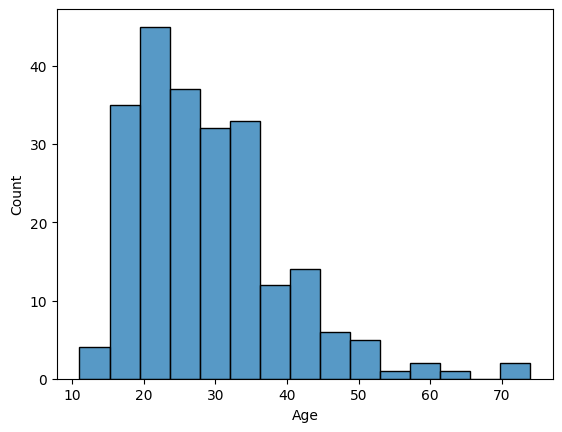

In [ ]:
sns.histplot(data=data_mr_male_3, x="Age")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

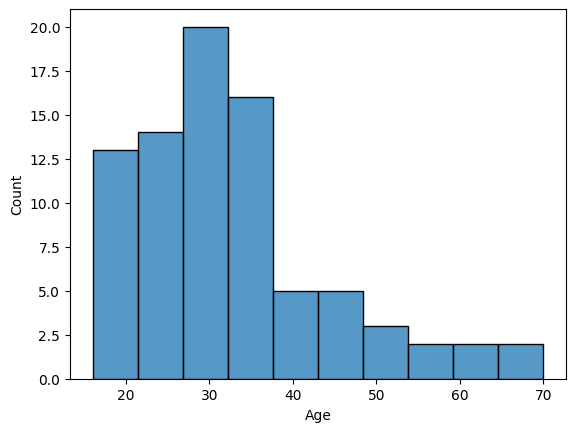

In [ ]:
sns.histplot(data=data_mr_male_2, x="Age")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

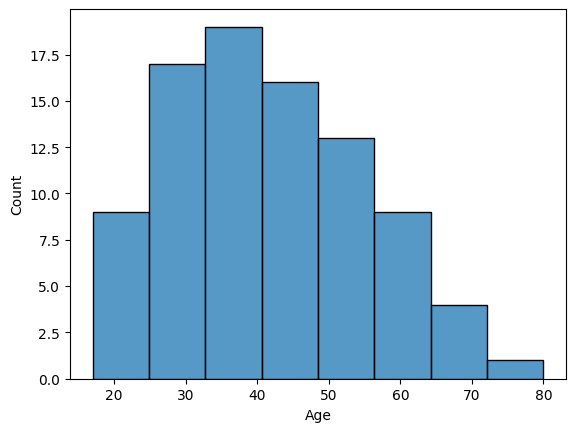

In [ ]:
sns.histplot(data=data_mr_male_1, x="Age")

In [ ]:
# Since it is skewed to the right, I think I'm going to impute it with the median as well
median_data_mr_male_3 = data_mr_male_3["Age"].median()
median_data_mr_male_2 = data_mr_male_2["Age"].median()
median_data_mr_male_1 = data_mr_male_1["Age"].median()

train_data.loc[
    (train_data.Name.str.contains('Mr.', regex=True)) &
    (train_data.Age.isna()) &
    (train_data.Sex == 'male') &
    (train_data.Pclass == 3),
    "Age"
] = median_data_mr_male_3

train_data.loc[
    (train_data.Name.str.contains('Mr.', regex=True)) &
    (train_data.Age.isna()) &
    (train_data.Sex == 'male') &
    (train_data.Pclass == 2),
    "Age"
] = median_data_mr_male_2

train_data.loc[
    (train_data.Name.str.contains('Mr.', regex=True)) &
    (train_data.Age.isna()) &
    (train_data.Sex == 'male') &
    (train_data.Pclass == 1),
    "Age"
] = median_data_mr_male_1

# Test data
test_data.loc[
    (test_data.Name.str.contains('Mr.', regex=True)) &
    (test_data.Age.isna()) &
    (test_data.Sex == 'male') &
    (test_data.Pclass == 3),
    "Age"
] = median_data_mr_male_3

test_data.loc[
    (test_data.Name.str.contains('Mr.', regex=True)) &
    (test_data.Age.isna()) &
    (test_data.Sex == 'male') &
    (test_data.Pclass == 2),
    "Age"
] = median_data_mr_male_2

test_data.loc[
    (test_data.Name.str.contains('Mr.', regex=True)) &
    (test_data.Age.isna()) &
    (test_data.Sex == 'male') &
    (test_data.Pclass == 1),
    "Age"
] = median_data_mr_male_1

The next one is for females, which I think is a little bit tricky because females have 2 main titles, which are "Miss." and "Mrs.".

In the following code, we can see that "Miss." has a much lower minimum, which is 0.75 compared to the minimum of "Mrs." which is 15.0.

I can assume that the title "Miss." is for females that are not married yet and "Mrs." is for females that are married.

Note: After a simple Google search, it is true that traditionally, "Mrs." is for married women.

In [ ]:
data_miss_female_3 = train_data[
    (train_data.Name.str.contains('Miss.', regex=True)) &
    (train_data.Age.notna()) &
    (train_data.Pclass == 3)
]

data_mrs_female_3 = train_data[
    (train_data.Name.str.contains('Mrs.', regex=True)) &
    (train_data.Age.notna()) &
    (train_data.Pclass == 3)
]

In [ ]:
print("Minimum age for title \"Miss\", Pclass 3: ", min(data_miss_female_3["Age"]))
print("Maximum age for title \"Miss\", Pclass 3: ", max(data_miss_female_3["Age"]), "\n")
print("Minimum age for title \"Mrs\", Pclass 3: ", min(data_mrs_female_3["Age"]))
print("Maximum age for title \"Mrs\", Pclass 3: ", max(data_mrs_female_3["Age"]))

Minimum age for title "Miss", Pclass 3:  0.75
Maximum age for title "Miss", Pclass 3:  45.0 

Minimum age for title "Mrs", Pclass 3:  15.0
Maximum age for title "Mrs", Pclass 3:  63.0


In [ ]:
print("Mean age for title \"Miss\", Pclass 3: ", data_miss_female_3["Age"].mean())
print("Median age for title \"Miss\", Pclass 3: ", data_miss_female_3["Age"].median())

Mean age for title "Miss", Pclass 3:  16.1231884057971
Median age for title "Miss", Pclass 3:  18.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

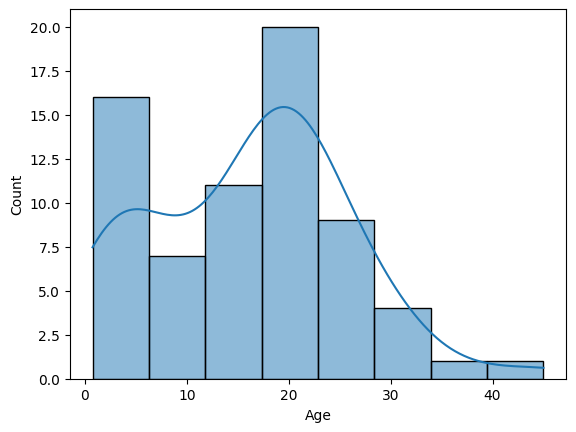

In [ ]:
sns.histplot(data=data_miss_female_3, x="Age", kde=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

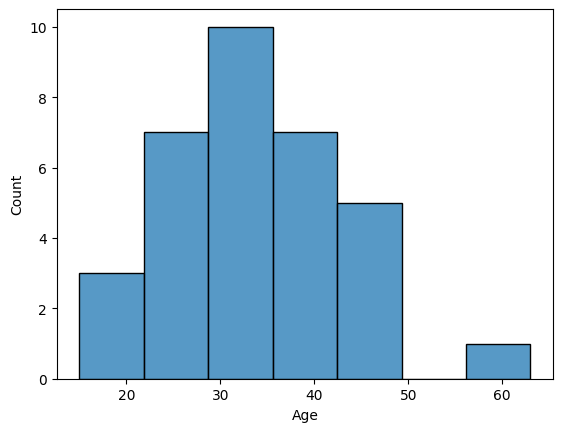

In [ ]:
sns.histplot(data=data_mrs_female_3, x="Age")

With the men name, "Master" has a maximum value of 12 and "Mr." has a minimum value of 11.

However, "Miss" has a maximum value of 45 and "Mrs." has a minimum value of 15. So, the distinction between "Miss" and "Mrs." is not very clear.

Maybe if we group it not only with Pclass, but also the SibSp and Parch, we can get a better estimate of the mean of the age, since logically, if the SibSp and Parch is 0, then the female is a solo traveller, and therefore, they should be old enough to travel alone.

In [ ]:
train_data[
    (train_data.Name.str.contains('Miss.', regex=True)) &
    (train_data.Age.notna())
].groupby(["Pclass", "SibSp", "Parch"])["Age"].agg(['mean', 'count'])

mean  count
Pclass SibSp Parch                  
1      0     0      33.750000     24
             1      17.250000      4
             2      25.200000      5
       1     0      40.800000      5
             1      39.000000      1
             2       8.000000      2
       2     2      19.500000      2
       3     2      23.500000      2
2      0     0      30.694444     18
             1      12.333333      3
             2      11.000000      3
       1     0      27.000000      1
             1      10.333333      3
             2      10.666667      3
       2     1       4.000000      1
3      0     0      22.263889     36
             1       6.500000      4
             2       5.000000      3
       1     0      18.916667      6
             1       4.666667      3
       2     0      18.000000      1
             1       2.166667      3
             2      15.000000      2
       3     1       5.500000      2
             2       5.500000      2
       4     2       8.333333      6
       5     2      16.000000      1

In [ ]:
mean_female_miss_training = train_data[
    (train_data.Name.str.contains('Miss.', regex=True)) &
    (train_data.Age.notna())
].groupby(["Pclass", "SibSp", "Parch"])["Age"].mean()

In [ ]:
mean_female_miss_training

Pclass  SibSp  Parch
1       0      0        33.750000
               1        17.250000
               2        25.200000
        1      0        40.800000
               1        39.000000
               2         8.000000
        2      2        19.500000
        3      2        23.500000
2       0      0        30.694444
               1        12.333333
               2        11.000000
        1      0        27.000000
               1        10.333333
               2        10.666667
        2      1         4.000000
3       0      0        22.263889
               1         6.500000
               2         5.000000
        1      0        18.916667
               1         4.666667
        2      0        18.000000
               1         2.166667
               2        15.000000
        3      1         5.500000
               2         5.500000
        4      2         8.333333
        5      2        16.000000
Name: Age, dtype: float64

The previous code creates a dataframe with a multiindex of Pclass, SibSp, and Parch, then gets the mean.

The next code for `imputation_map_series` will create the same multiindex with the `mean_female_miss_training` and convert it into a series.

Basically, `imputation_map_series` will do set_index based on the Pclass, SibSp, and Parch (the same as `mean_female_miss_training`), and then based on each index, it will map the value in `mean_female_miss_training` to each row no matter the female or male.

Now, there will be some combinations of Pclass, SibSp, and Parch that does not exist in `mean_female_miss_training` but exist in `imputation_map_series`, which is why there will be some value that are NaN in `imputation_map_series`. I will impute those later.

In [ ]:
imputation_map_series = pd.Series(train_data.set_index(
    ["Pclass", "SibSp", "Parch"]
).index.map(
    mean_female_miss_training
))

condition = (train_data.Name.str.contains('Miss.', regex=True, na=False)) & (train_data.Age.isna())

train_data.loc[condition, "Age"] = imputation_map_series.loc[condition]

In [ ]:
# Do the same with test_data
test_imputation_map_series = pd.Series(test_data.set_index(
    ["Pclass", "SibSp", "Parch"]
).index.map(
    mean_female_miss_training # Still use the training's mean
))

condition_miss_test = (test_data.Name.str.contains('Miss.', regex=True, na=False)) & (test_data.Age.isna())

test_data.loc[condition_miss_test, "Age"] = test_imputation_map_series.loc[condition_miss_test]

In [ ]:
# Now, we can see that there are still "Miss." with missing age value.
# It is because the combination of Pclass, SibSp, and Parch of these people
# does not exist in mean_female_miss_training
train_data[
    (train_data.Name.str.contains('Miss.', regex=True)) &
    (train_data.Age.isna())
]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S


In [ ]:
# Luckily, all of them are Pclass 3. Therefore, I can use the mean that I have calculated before, which is
# about 16.0

train_data.loc[
    (train_data.Name.str.contains('Miss.', regex=True)) &
    (train_data.Age.isna()),
    "Age"
] = 16.0

test_data.loc[
    (test_data.Name.str.contains('Miss.', regex=True)) &
    (test_data.Age.isna()),
    "Age"
] = 16.0

In [ ]:
# We do the same with Mrs. title
data_mrs_female_3 = train_data[
    (train_data.Name.str.contains("Mrs.")) &
    (train_data.Age.notna()) &
    (train_data.Pclass == 3)
]

data_mrs_female_2 = train_data[
    (train_data.Name.str.contains("Mrs.")) &
    (train_data.Age.notna()) &
    (train_data.Pclass == 2)
]

data_mrs_female_1 = train_data[
    (train_data.Name.str.contains("Mrs.")) &
    (train_data.Age.notna()) &
    (train_data.Pclass == 1)
]

In [ ]:
print("Median of Mrs. with Pclass 3: ", data_mrs_female_3["Age"].median())
print("Mean of Mrs. with Pclass 3: ", data_mrs_female_3["Age"].mean(), "\n")
print("Median of Mrs. with Pclass 2: ", data_mrs_female_2["Age"].median())
print("Mean of Mrs. with Pclass 2: ", data_mrs_female_2["Age"].mean(), "\n")
print("Median of Mrs. with Pclass 1: ", data_mrs_female_1["Age"].median())
print("Mean of Mrs. with Pclass 1: ", data_mrs_female_1["Age"].mean())

Median of Mrs. with Pclass 3:  31.0
Mean of Mrs. with Pclass 3:  33.515151515151516 

Median of Mrs. with Pclass 2:  31.0
Mean of Mrs. with Pclass 2:  33.116279069767444 

Median of Mrs. with Pclass 1:  41.5
Mean of Mrs. with Pclass 1:  40.611111111111114


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

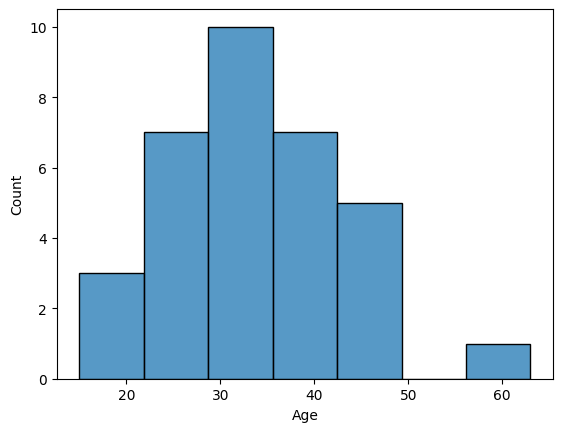

In [ ]:
sns.histplot(data=data_mrs_female_3, x="Age")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

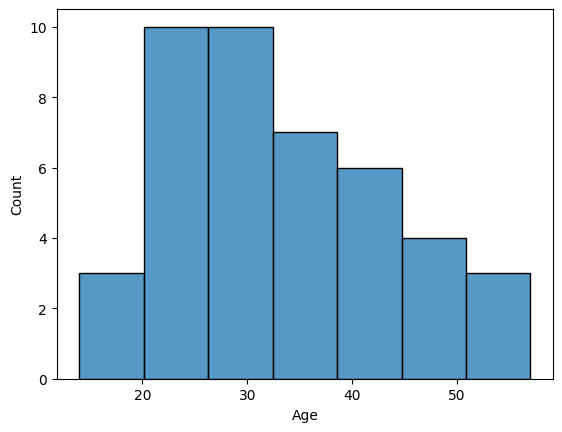

In [ ]:
sns.histplot(data=data_mrs_female_2, x="Age")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

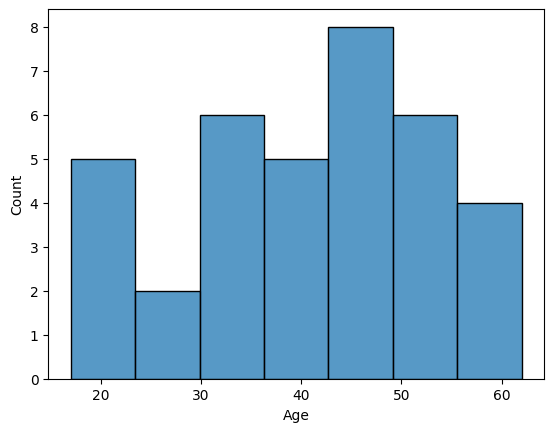

In [ ]:
sns.histplot(data=data_mrs_female_1, x="Age")

In [ ]:
train_data[
    (train_data.Name.str.contains('Mrs.', regex=True)) &
    (train_data.Age.notna())
].groupby(["Pclass", "SibSp", "Parch"])["Age"].agg(['mean', 'count'])

mean  count
Pclass SibSp Parch                  
1      0     0      44.500000      4
             1      50.200000      5
       1     0      36.500000     18
             1      43.666667      6
             2      30.500000      2
       2     0      53.000000      1
2      0     0      35.692308     13
             1      37.500000      4
             2      28.500000      2
       1     0      29.090909     11
             1      33.000000      6
             2      34.333333      3
             3      54.000000      1
       2     1      24.000000      1
             3      24.000000      1
       3     0      30.000000      1
3      0     0      47.000000      2
             1      30.000000      3
             2      30.250000      4
             3      24.000000      1
             4      29.000000      1
             5      40.000000      2
       1     0      29.625000      8
             1      30.833333      6
             3      48.000000      1
             4      45.000000      1
             5      38.500000      2
             6      43.000000      1
       3     0      33.000000      1

In [ ]:
mean_female_mrs_training = train_data[
    (train_data.Name.str.contains('Mrs.', regex=True)) &
    (train_data.Age.notna())
].groupby(["Pclass", "SibSp", "Parch"])["Age"].mean()

In [ ]:
imputation_map_series = pd.Series(train_data.set_index(
    ["Pclass", "SibSp", "Parch"]
).index.map(
    mean_female_mrs_training
))

condition = (train_data.Name.str.contains('Mrs.', regex=True, na=False)) & (train_data.Age.isna())

train_data.loc[condition, "Age"] = imputation_map_series.loc[condition]

In [ ]:
test_imputation_map_series = pd.Series(test_data.set_index(
    ["Pclass", "SibSp", "Parch"]
).index.map(
    mean_female_mrs_training
))

condition = (test_data.Name.str.contains('Mrs.', regex=True, na=False)) & (test_data.Age.isna())

test_data.loc[condition, "Age"] = test_imputation_map_series.loc[condition]

In [ ]:
train_data[
    train_data.Age.isna()
]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6,NaN,C


In [ ]:
# I will assume that the Dr. is as old as the median age of Mr. in Pclass 1
train_data.loc[
    train_data.PassengerId == 767,
    "Age"
] = median_data_mr_male_1

In [ ]:
test_data[
    test_data.Age.isna()
]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
88,980,3,"O'Donoghue, Ms. Bridget",female,NaN,0,0,364856,7.75,NaN,Q
365,1257,3,"Sage, Mrs. John (Annie Bullen)",female,NaN,1,9,CA. 2343,69.55,NaN,S


In [ ]:
# I will also use the same value of the mean age of Mrs. with Pclass 3
test_data.loc[
    (test_data.PassengerId == 925) |
    (test_data.PassengerId == 980) |
    (test_data.PassengerId == 1257),
    "Age"
] = 33

In [ ]:
# Let's see NaN value of Embarked in train_data
train_data[
    train_data.Embarked.isna()
]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [ ]:
train_data[
    train_data.Pclass == 1
].groupby(["Embarked"])["Fare"].agg(["mean", "median", "count"])

,mean,median,count
Embarked,,,
C,104.718529,78.2667,85
Q,90.000000,90.0000,2
S,70.364862,52.0000,127


In [ ]:
# I think the safest way to impute the embarked is by imputing it with 'C', because the fare value is quite similar.
train_data.loc[
    (train_data.PassengerId == 62) |
    (train_data.PassengerId == 830),
    "Embarked"
] = 'C'

In [ ]:
# Let's see the missing Fare in test_data
test_data[
    test_data.Fare.isna()
]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [ ]:
# I will impute it based on the following mean
mean_temp = test_data[
    (test_data.SibSp == 0) &
    (test_data.Parch == 0) &
    (test_data.Embarked == 'S') &
    (test_data.Pclass == 3) &
    (test_data.Sex == 'male')
]["Fare"].mean()

test_data.loc[
    test_data.PassengerId == 1044,
    "Fare"
] = round(mean_temp)

In [ ]:
round(train_data.isna().sum().sort_values(ascending=False)/len(train_data) * 100, 1)

Cabin          77.1
PassengerId     0.0
Survived        0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Embarked        0.0
dtype: float64

In [ ]:
round(test_data.isna().sum().sort_values(ascending=False)/len(test_data) * 100, 1)

Cabin          78.2
PassengerId     0.0
Pclass          0.0
Name            0.0
Sex             0.0
Age             0.0
SibSp           0.0
Parch           0.0
Ticket          0.0
Fare            0.0
Embarked        0.0
dtype: float64

Since the Cabin column has too much missing values, I don't think it has enough data to be imputed.

## Picking the Features

In [ ]:
female_survive = train_data[train_data.Sex == 'female']["Survived"]
male_survive = train_data[train_data.Sex == 'male']["Survived"]

print(f"% of females who survived: {sum(female_survive)/len(female_survive)}")
print(f"% of males who survived: {sum(male_survive)/len(male_survive)}\n")

pclass_1 = train_data[train_data.Pclass == 1]["Survived"]
rate_1_survived = sum(pclass_1)/len(pclass_1)

pclass_2 = train_data[train_data.Pclass == 2]["Survived"]
rate_2_survived = sum(pclass_2)/len(pclass_2)

pclass_3 = train_data[train_data.Pclass == 3]["Survived"]
rate_3_survived = sum(pclass_3)/len(pclass_3)

print(f"% of people in first class who survived: {rate_1_survived}")
print(f"% of people in second class who survived: {rate_2_survived}")
print(f"% of people in third class who survived: {rate_3_survived}\n")
print("---------------------------------------------------------------")

pclass_1_male = train_data[(train_data.Pclass == 1) & (train_data.Sex == 'male')]["Survived"]
rate_1_male_survived = sum(pclass_1_male)/len(pclass_1_male)
pclass_1_female = train_data[(train_data.Pclass == 1) & (train_data.Sex == 'female')]["Survived"]
rate_1_female_survived = sum(pclass_1_female)/len(pclass_1_female)

pclass_2_male = train_data[(train_data.Pclass == 2) & (train_data.Sex == 'male')]["Survived"]
rate_2_male_survived = sum(pclass_2_male)/len(pclass_2_male)
pclass_2_female = train_data[(train_data.Pclass == 2) & (train_data.Sex == 'female')]["Survived"]
rate_2_female_survived = sum(pclass_2_female)/len(pclass_2_female)

pclass_3_male = train_data[(train_data.Pclass == 3) & (train_data.Sex == 'male')]["Survived"]
rate_3_male_survived = sum(pclass_3_male)/len(pclass_3_male)
pclass_3_female = train_data[(train_data.Pclass == 3) & (train_data.Sex == 'female')]["Survived"]
rate_3_female_survived = sum(pclass_3_female)/len(pclass_3_female)

print(f"% of males in first class who survived: {rate_1_male_survived}")
print(f"% of females in first class who survived: {rate_1_female_survived}\n")
print(f"% of males in second class who survived: {rate_2_male_survived}")
print(f"% of females in second class who survived: {rate_2_female_survived}\n")
print(f"% of males in third class who survived: {rate_3_male_survived}")
print(f"% of females in third class who survived: {rate_3_female_survived}\n")

% of females who survived: 0.7420382165605095
% of males who survived: 0.18890814558058924

% of people in first class who survived: 0.6296296296296297
% of people in second class who survived: 0.47282608695652173
% of people in third class who survived: 0.24236252545824846

---------------------------------------------------------------
% of males in first class who survived: 0.36885245901639346
% of females in first class who survived: 0.9680851063829787

% of males in second class who survived: 0.1574074074074074
% of females in second class who survived: 0.9210526315789473

% of males in third class who survived: 0.13544668587896252
% of females in third class who survived: 0.5



So we know that Pclass and Sex are good indicators for survival. Maybe we can try combining Pclass and Sex.

In [ ]:
train_data["Pclass_Sex"] = train_data["Pclass"].astype(str) + train_data["Sex"]
test_data["Pclass_Sex"] = test_data["Pclass"].astype(str) + test_data["Sex"]

In [ ]:
train_data["NumOfRelations"] = train_data["SibSp"] + train_data["Parch"]
test_data["NumOfRelations"] = test_data["SibSp"] + test_data["Parch"]

<Axes: xlabel='NumOfRelations', ylabel='count'>

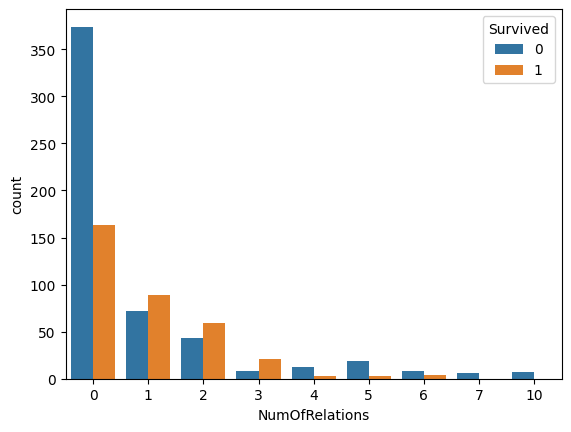

In [ ]:
sns.countplot(train_data, x='NumOfRelations', hue="Survived")

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_Sex,NumOfRelations
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3male,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1female,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3female,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1female,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3male,0


In [ ]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_Sex,NumOfRelations
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,3male,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,3female,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,2male,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,3male,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,3female,2


## Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [ ]:
X_train = train_data[["Pclass_Sex", "NumOfRelations"]]
y_train = train_data["Survived"]

X_test = test_data[["Pclass_Sex", "NumOfRelations"]]

In [ ]:
# Split training dataset
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
nominal_cols = ["Pclass_Sex"]
numerical_cols = ["NumOfRelations"]
# ordinal_cols = ["Pclass_Sex"]

# pclass_order = ["1male", "1female", "2male", "2female", "3male", "3female"]
# pclass_order = [1, 2, 3]

In [ ]:
ct = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols),
        ("standard_scaler", StandardScaler(), numerical_cols),
        # ("ord", OrdinalEncoder(categories=[pclass_order]), ordinal_cols)
    ],
    remainder="passthrough"
)

In [ ]:
X_train_enc = ct.fit_transform(X_train_split)
X_val_enc = ct.transform(X_val)
X_test_enc = ct.transform(X_test)

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_enc, y_train_split)

LogisticRegression(random_state=42)

In [ ]:
y_pred_lr = lr.predict(X_val_enc)

In [ ]:
clf = RandomForestClassifier(random_state=42, max_depth=5)
clf.fit(X_train_enc, y_train_split)

RandomForestClassifier(max_depth=5, random_state=42)

In [ ]:
y_pred_tree = clf.predict(X_val_enc)

In [ ]:
xgb = XGBClassifier(random_state=42, n_estimators=100, max_depth=6, reg_lambda=1200)
xgb.fit(X_train_enc, y_train_split)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_xgb = xgb.predict(X_val_enc)

In [ ]:
ct.get_feature_names_out()

array(['ohe__Pclass_Sex_1female', 'ohe__Pclass_Sex_1male',
       'ohe__Pclass_Sex_2female', 'ohe__Pclass_Sex_2male',
       'ohe__Pclass_Sex_3female', 'ohe__Pclass_Sex_3male',
       'standard_scaler__NumOfRelations'], dtype=object)

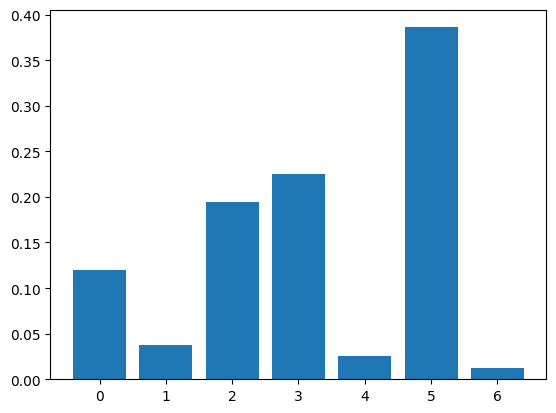

In [ ]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [ ]:
print("Logistic Regression")
print(f"Accuracy on training set: {lr.score(X_train_enc, y_train_split)}")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_pred_lr)}")

Logistic Regression
Accuracy on training set: 0.8033707865168539
Accuracy on validation set: 0.8044692737430168


In [ ]:
print("Random Forest Classifier")
print(f"Accuracy on training set: {clf.score(X_train_enc, y_train_split)}")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_pred_tree)}")

Random Forest Classifier
Accuracy on training set: 0.8160112359550562
Accuracy on validation set: 0.8044692737430168


In [ ]:
print("XGBoost")
print(f"Accuracy on training set: {xgb.score(X_train_enc, y_train_split)}")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_pred_xgb)}")

XGBoost
Accuracy on training set: 0.8132022471910112
Accuracy on validation set: 0.7988826815642458


## Submission

In [ ]:
predictions = lr.predict(X_test_enc)

In [ ]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
